# Steel Plate Detection Prediction

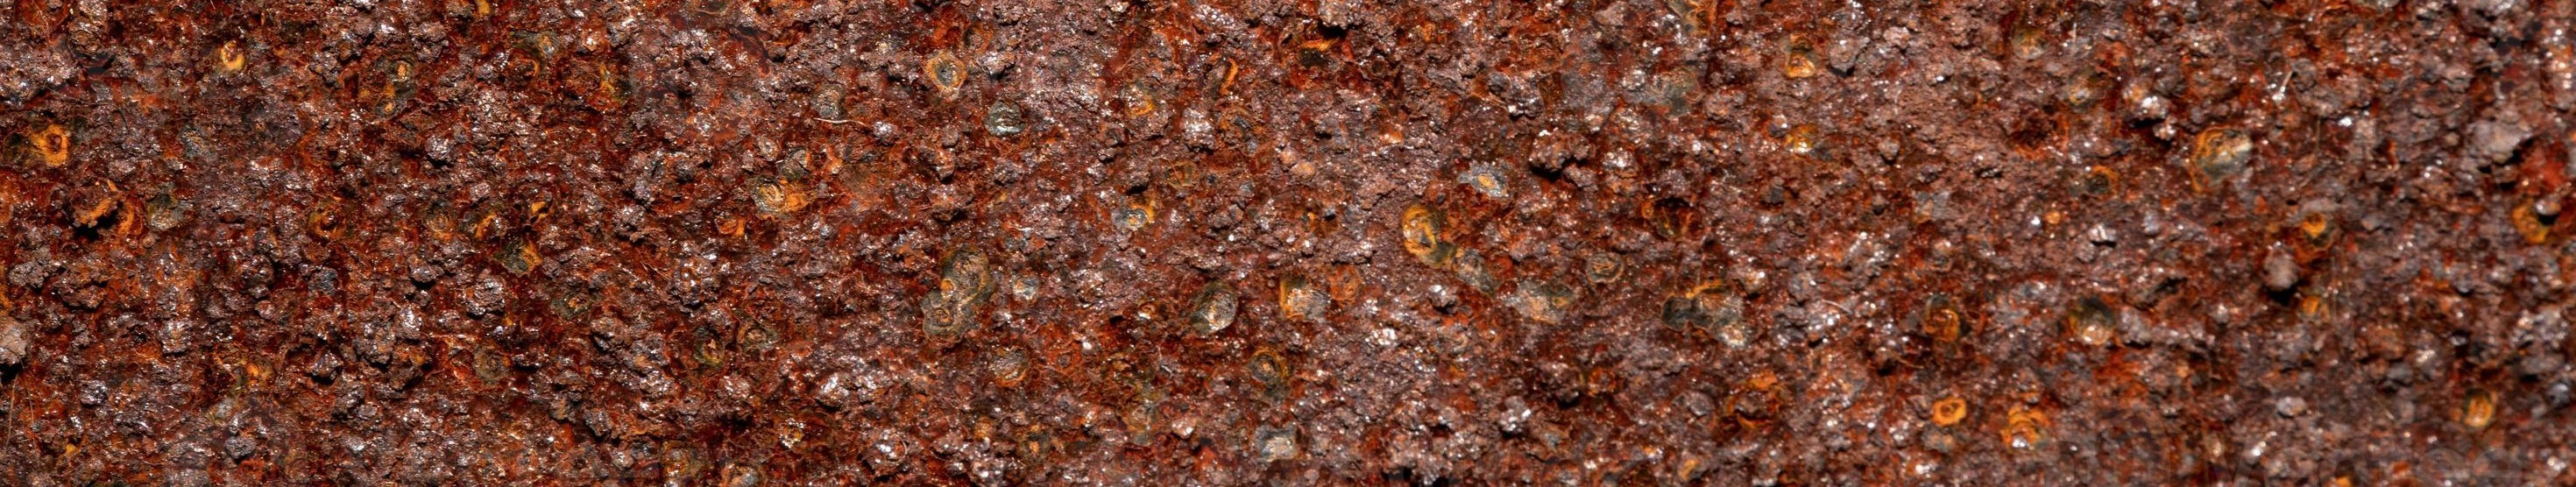

1. __Dataset Description__
The dataset for this competition (both train and test) was generated from a deep learning model trained on the Steel Plates Faults dataset from UCI. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

2. __Files__
`train.csv` - the training dataset; there are 7 binary targets: `Pastry`, `Z_Scratch`, `K_Scatch`, `Stains`, `Dirtiness`, `Bumps`, `Other_Faults`
`test.csv` - the test dataset; your objective is to predict the probability of each of the 7 binary targets
`sample_submission.csv` - a sample submission file in the correct format

3. __Evaluation__
Submissions are evaluated using area under the ROC curve using the predicted probabilities and the ground truth targets.
To calculate the final score, AUC is calculated for each of the 7 defect categories and then averaged. In other words, the score is the average of the individual AUC of each predicted column.

4. __Submission File__
For each id in the test set, you must predict the probability for each of 7 defect categories: Pastry, Z_Scratch, K_Scatch, Stains, Dirtiness, Bumps, Other_Faults. The file should contain a header and have the following format:

    ```python
    id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
    19219,0.5,0.5,0.5,0.5,0.5,0.5,0.5
    19220,0.5,0.5,0.5,0.5,0.5,0.5,0.5
    19221,0.5,0.5,0.5,0.5,0.5,0.5,0.5
    etc.
    ```

5. __Citation__
    * <a href="https://kaggle.com/competitions/playground-series-s4e3">Walter Reade, Ashley Chow, Steel Plate Defect Prediction, Kaggle, 2024</a>

## Import Dependencies

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

## Import Datasets

In [277]:
data = pd.read_csv('./data/train.csv', header=0, index_col=0)
test = pd.read_csv('./data/test.csv', header=0, index_col=0)

In [3]:
data.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
id,,,,,,,,,,,,,,,,,,,,,
0,584,590,909972,909977,16,8,5,2274,113,140,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,808,816,728350,728372,433,20,54,44478,70,111,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,781,789,3353146,3353173,210,16,29,3202,114,134,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,1540,1560,618457,618502,521,72,67,48231,82,111,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


In [4]:
test.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
id,,,,,,,,,,,,,,,,,,,,,
19219,1015,1033,3826564,3826588,659,23,46,62357,67,127,...,0.0095,0.5652,1.0000,1.0,2.8410,1.1139,1.6628,0.6727,-0.2261,0.9172
19220,1257,1271,419960,419973,370,26,28,39293,92,132,...,0.0047,0.2414,1.0000,1.0,2.5682,0.9031,1.4472,0.9063,-0.1453,0.9104
19221,1358,1372,117715,117724,289,36,32,29386,101,134,...,0.0155,0.6000,0.7500,0.0,2.4609,1.3222,1.3222,-0.5238,-0.0435,0.6514
19222,158,168,232415,232440,80,10,11,8586,107,140,...,0.0037,0.8000,1.0000,1.0,1.9031,0.6990,1.0414,0.1818,-0.0738,0.2051
19223,559,592,544375,544389,140,19,15,15524,103,134,...,0.0158,0.8421,0.5333,0.0,2.1461,1.3222,1.1461,-0.5714,-0.0894,0.4170


In [5]:
target_columns = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
target = data[target_columns]
train = data.drop(target_columns, axis=1)

In [6]:
target.head()

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
id,,,,,,,
0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1


In [7]:
train.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
id,,,,,,,,,,,,,,,,,,,,,
0,584,590,909972,909977,16,8,5,2274,113,140,...,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417
1,808,816,728350,728372,433,20,54,44478,70,111,...,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,...,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000
3,781,789,3353146,3353173,210,16,29,3202,114,134,...,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025
4,1540,1560,618457,618502,521,72,67,48231,82,111,...,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998


In [94]:
train.shape

(19219, 27)

In [95]:
test.shape

(12814, 27)

In [8]:
# train.isna().sum() # no missing values
# test.isna().sum() # no missing values

## Explore Dataset (EDA)

### Data Distribution
Methods used to plot histogram includes:
1. `count`: The height of the bars represents the number of observations (i.e., frequency) in each bin.
    * Use: Exploratory data abakysis (EDA), when assessing how many data fall within specific ranges, good for understanding the raw distribution of data

2. `density`: The height of the bars represents the proportion of data within each bin, normalized so that the total area of the histogram equals 1.
    * Use: When comparing distributions with different sample sizes, it allows comparison without being worried about being biased by the total number of samples.

3. `probability`: Similar to `density`, but the total area of the histogram equals 1, and the bars show the proportion of observations in each bin.
    * Use: When it is intended to have the height of the bars to represent the proportion of observations in each bin. This is essentially the same as density but in terms of the proportion of samples per bin (rather than normalized density). It is useful when the relative probability of observations falling into each bin is a concern. It is useful in situations where the histogram is going to be interpreted as a discrete probability distribution, with each bin representing a portion of the whole.

4. `precent`: The height of the bars represents the percentage of observations in each bin.
    * Use: To display the percentage of data in each bin. This is particularly useful in presentations or when communicating results to non-technical audiences, as percentages can be more intuitive than counts or densities.

5. `frequency`: The height of the bars represents the number of observations (same as `count`).
    * Use: Raw data analysis.


array([[<Axes: title={'center': 'Pastry'}>,
        <Axes: title={'center': 'Z_Scratch'}>,
        <Axes: title={'center': 'K_Scatch'}>],
       [<Axes: title={'center': 'Stains'}>,
        <Axes: title={'center': 'Dirtiness'}>,
        <Axes: title={'center': 'Bumps'}>],
       [<Axes: title={'center': 'Other_Faults'}>, <Axes: >, <Axes: >]],
      dtype=object)

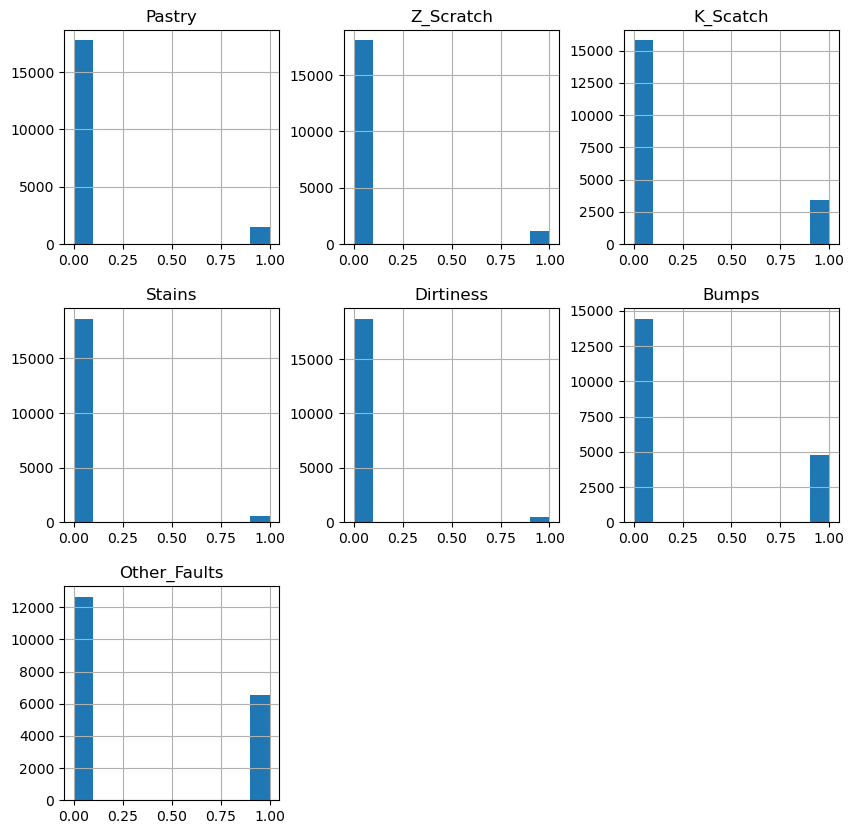

In [26]:
target.hist(figsize=(10, 10))

#### Feature Distribution

In [209]:
def overlay_hist(train_df, test_df, ncols):
    nrows = ceil(train_df.shape[1]/ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3 * nrows))
    axes = axes.flatten()
    features = train_df.columns
    for i in range(len(axes)):
        try:
            feature = features[i]
            sns.histplot(train_df[feature], color='black', linewidth=1.0, fill=False, label='Training Data', kde=False, stat='density', bins=30, alpha=1.0, ax=axes[i])
            sns.histplot(test_df[feature], color='red', linewidth=1.0, linestyle='--', fill=False, label='Test Data', kde=False, stat='density', bins=30, alpha=1.0, ax=axes[i])
            axes[i].set_xlabel(feature)
            axes[i].grid(False)
        except IndexError:
            fig.delaxes(axes[i])
    fig.suptitle('Overlay of Training and Test Data Histograms', y=1.01)
    handles, labels = axes[0].get_legend_handles_labels()    
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=2, fontsize='medium')
    plt.tight_layout()
    plt.show()

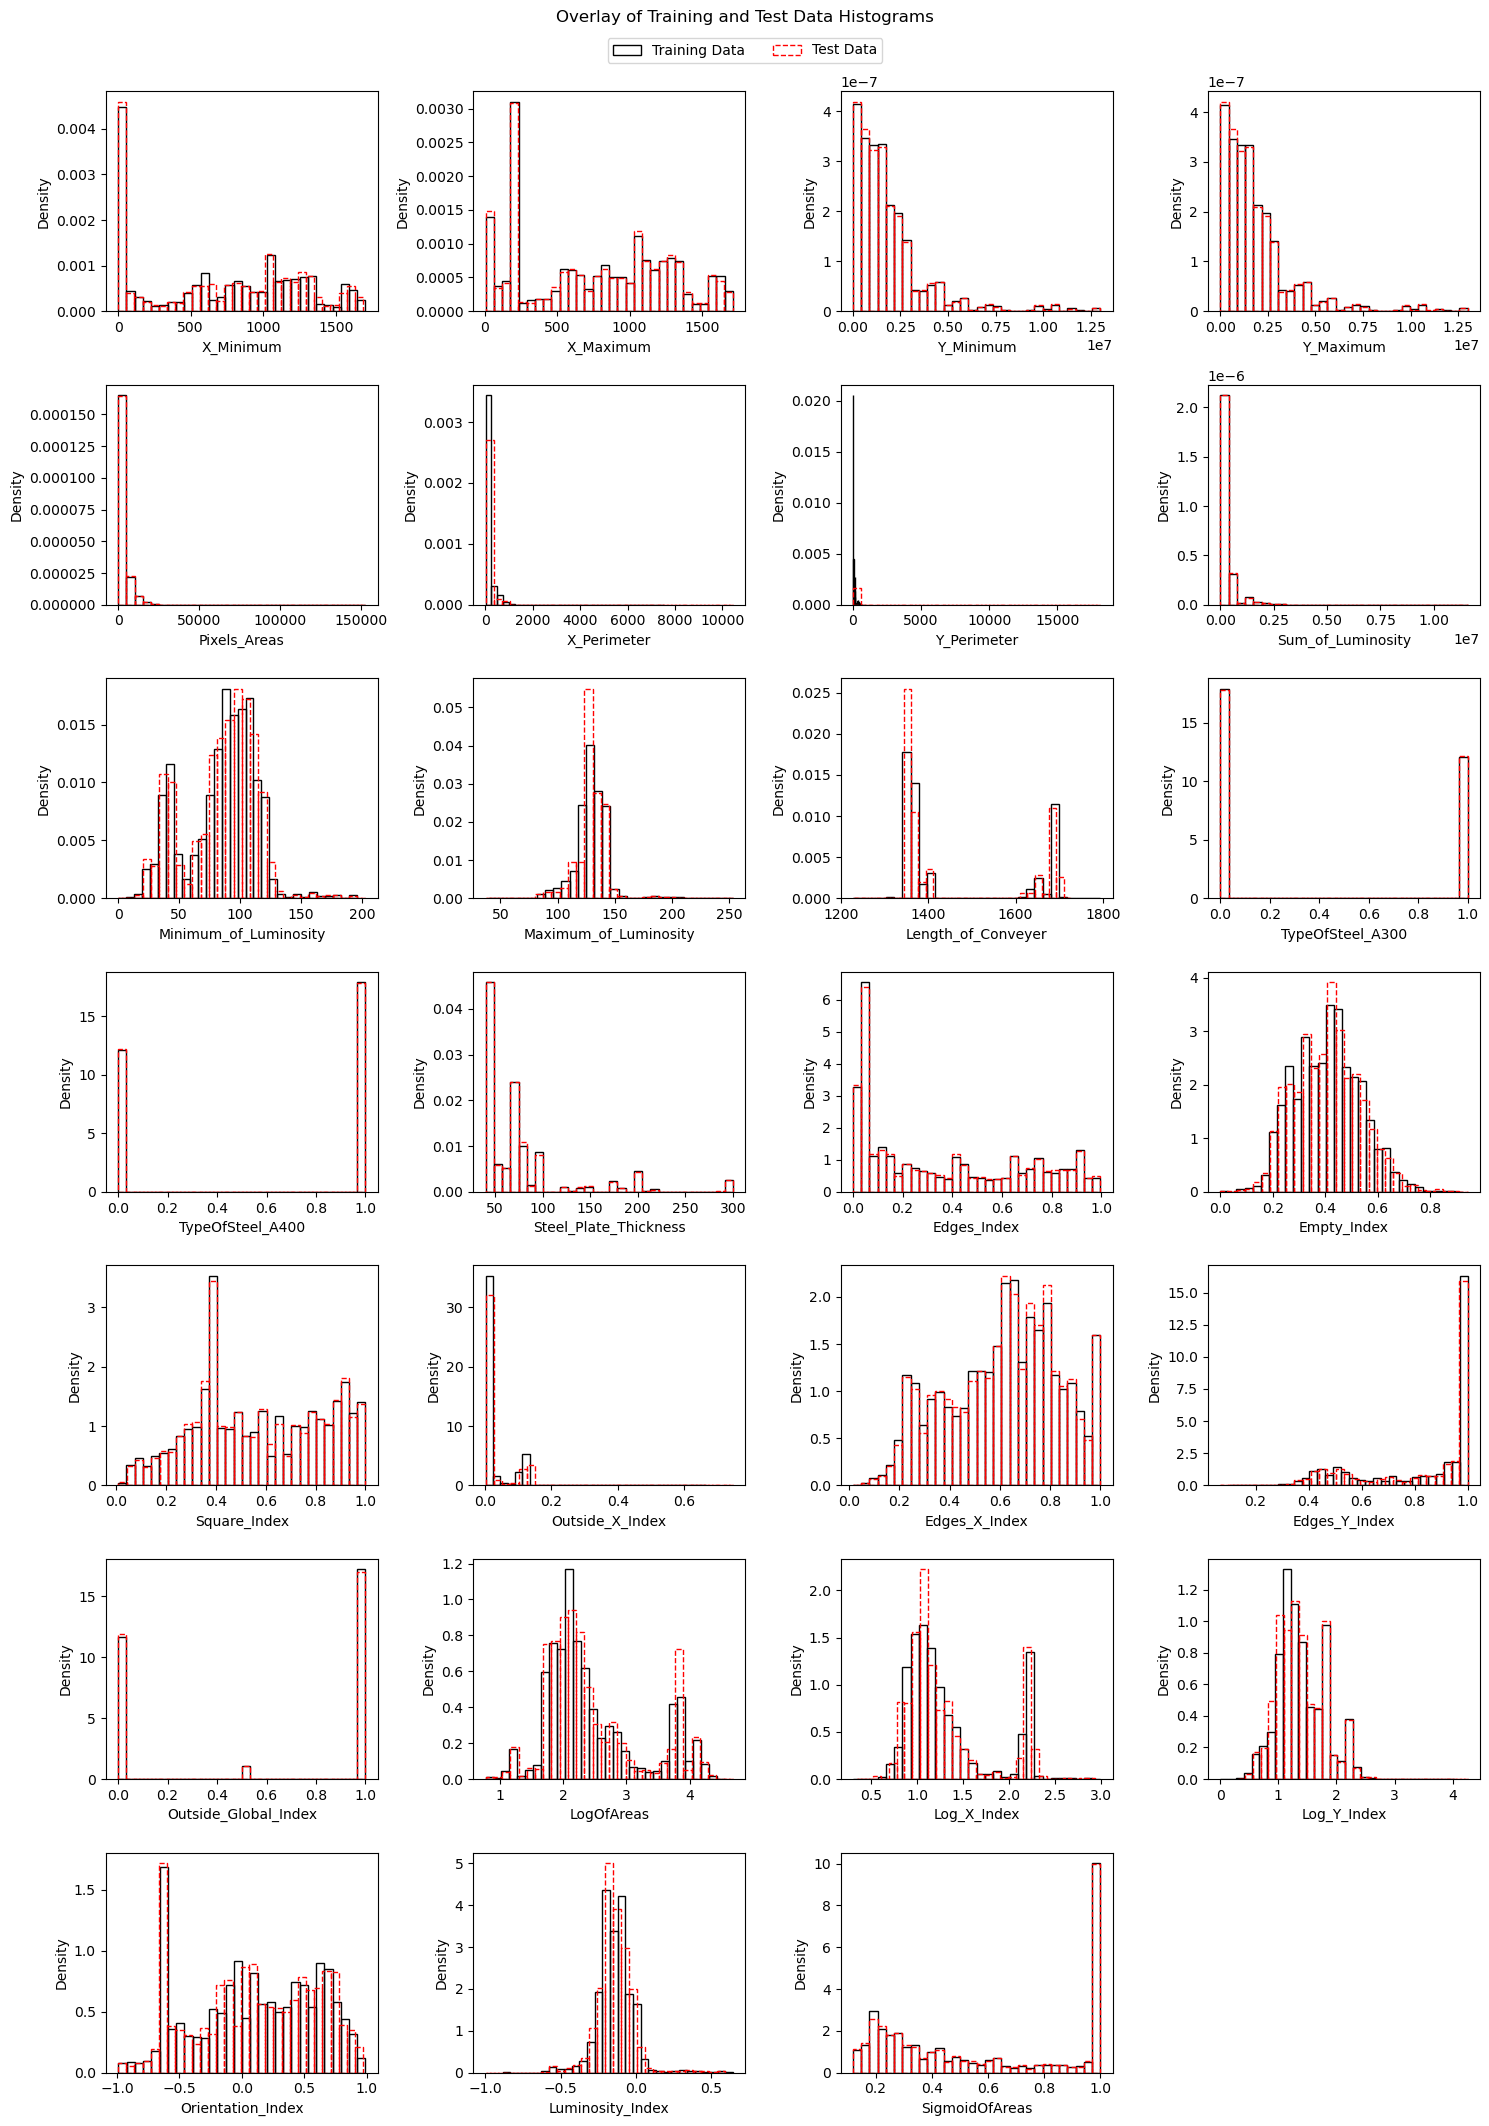

In [210]:
overlay_hist(train, test, 4)

The distribution of both `train` and `test` datasets are comparable with the exception of `Y_Perimeter`. Let's check its histogram more closely.

In [278]:
def compare_hist(train_df, test_df, feature, bins=10, stat_method='density'):
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 5))
    
    sns.histplot(train_df[feature], color='black', linewidth=1.0, fill=False, label='Training Data', kde=False, stat=stat_method, bins=bins, alpha=1.0, ax=axes[0])
    sns.histplot(test_df[feature], color='red', linewidth=1.0, linestyle='--', fill=False, label='Test Data', kde=False, stat=stat_method, bins=bins, alpha=1.0, ax=axes[1])
    axes[0].legend()
    axes[1].legend()
    
    plt.suptitle(f'Comparison of [{feature}] Histogram')
    plt.xlabel(feature)
    plt.ylabel('Density')
    
    plt.tight_layout()
    plt.show()

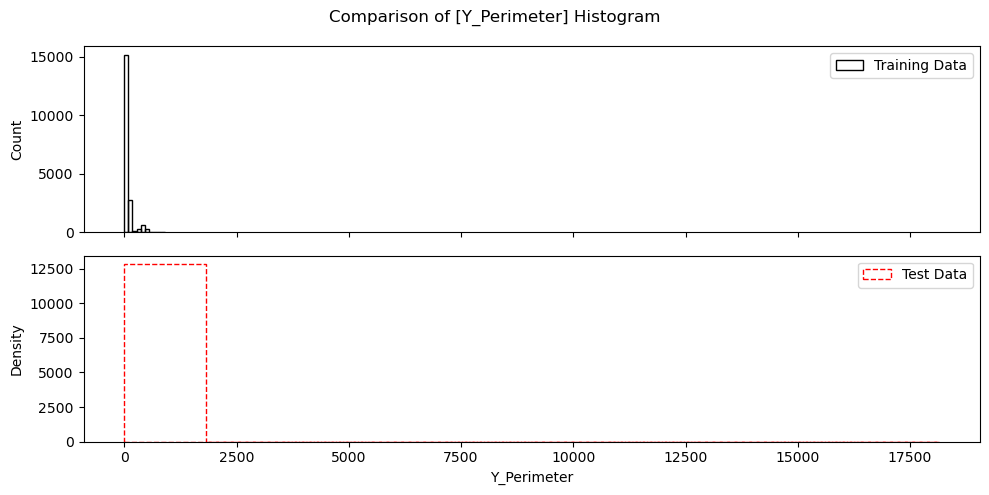

In [279]:
compare_hist(train, test, 'Y_Perimeter', bins=10, stat_method='count')

In [280]:
pd.concat([train['Y_Perimeter'].describe(), test['Y_Perimeter'].describe()], axis=1, keys=['Train', 'Test'])

,Train,Test
count,19219.000000,12814.000000
mean,64.124096,64.730607
std,101.054178,188.506385
min,1.000000,2.000000
25%,14.000000,14.000000
50%,23.000000,24.000000
75%,61.000000,60.000000
max,903.000000,18152.000000


The maximum value of `Y_perimeter` in the `test` set is extremely large. Let's check it out by taking a look at the strip plot of this feature.

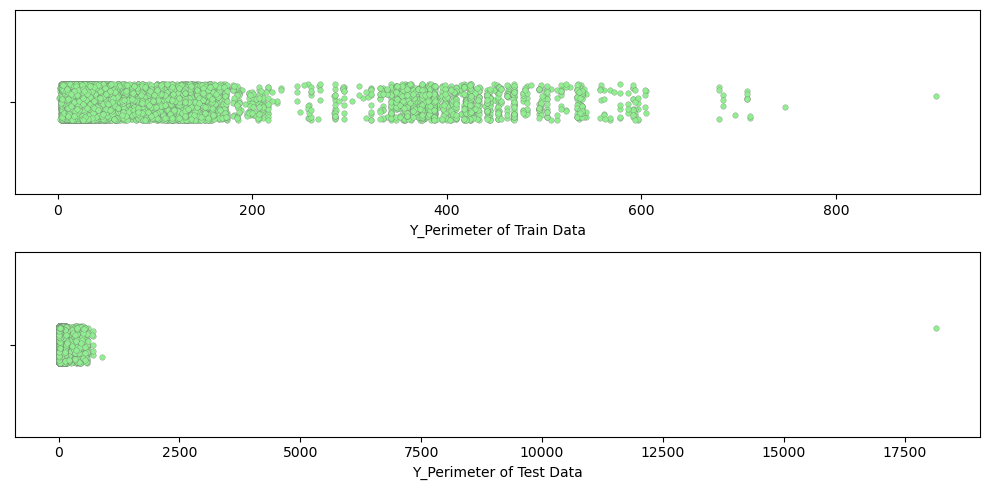

In [281]:
def get_iqr(df, feature):
    M = df[feature].median()
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    LB = Q1 - 1.5 * IQR # Lower Bound
    UB = Q3 + 1.5 * IQR # Upper Bound
    return M, Q1, Q3, LB, UB
    
def add_iqr(ax, df, feature):
    result = get_iqr(df, feature)   
    for item in result:
        ax.axvline(item, color='grey', linestyle='-', linewidth=1.0)

    
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))
feature = 'Y_Perimeter'
sns.stripplot(x=train[feature], color='lightgreen', size=4, dodge=True, jitter=True, linewidth=0.2, ax=axes[0])
sns.stripplot(x=test[feature], color='lightgreen', size=4, dodge=True, jitter=True, linewidth=0.2, ax=axes[1])
axes[0].set_xlabel(f'{feature} of Train Data')
axes[1].set_xlabel(f'{feature} of Test Data')

# add_iqr(axes[0], train, feature)
# add_iqr(axes[1], test, feature)

plt.tight_layout()
plt.show()

In [282]:
train['Y_Perimeter'].value_counts().sort_index()

1        1
2        5
3       45
4      346
5      155
      ... 
696      1
709      5
712      2
748      1
903      1
Name: Y_Perimeter, Length: 331, dtype: int64

In [283]:
test['Y_Perimeter'].value_counts().sort_index()

2          2
3         24
4        246
5        115
6        116
        ... 
684        1
709        2
712        3
903        1
18152      1
Name: Y_Perimeter, Length: 316, dtype: int64

The sigle extreme value in the text dataset is replaced with the median and then the strip plots are compared again.

In [284]:
# Replace max value with median
test['Y_Perimeter'] = test['Y_Perimeter'].replace(test['Y_Perimeter'].max(), test['Y_Perimeter'].median())

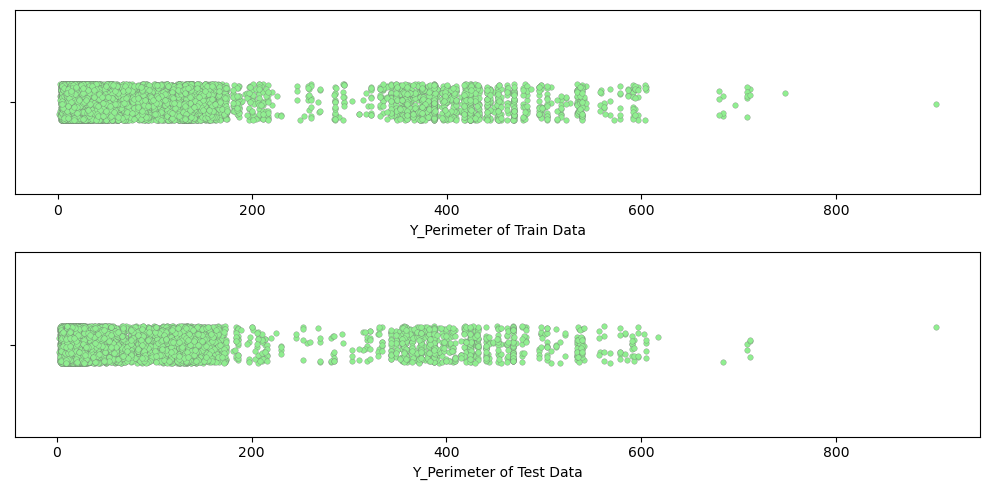

In [285]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))
feature = 'Y_Perimeter'
sns.stripplot(x=train[feature], color='lightgreen', size=4, dodge=True, jitter=True, linewidth=0.2, ax=axes[0])
sns.stripplot(x=test[feature], color='lightgreen', size=4, dodge=True, jitter=True, linewidth=0.2, ax=axes[1])
axes[0].set_xlabel(f'{feature} of Train Data')
axes[1].set_xlabel(f'{feature} of Test Data')

plt.tight_layout()
plt.show()

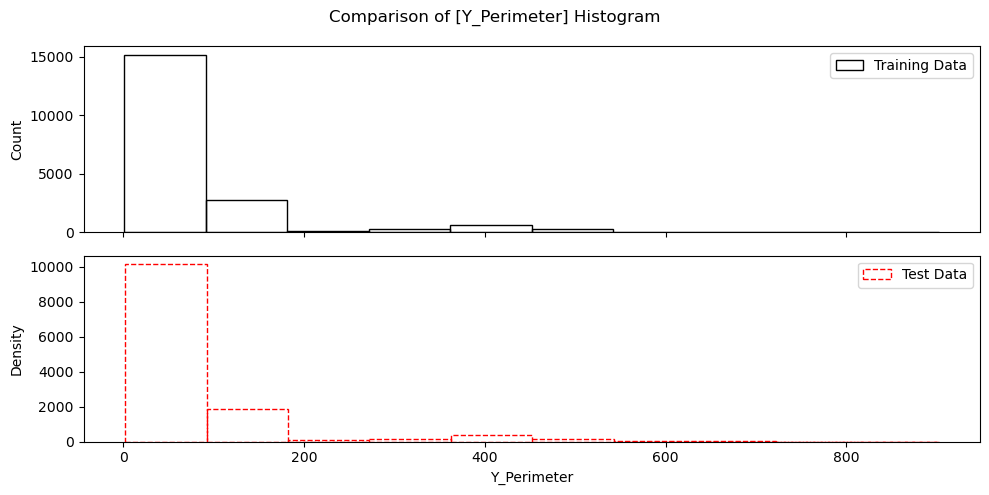

In [286]:
compare_hist(train, test, 'Y_Perimeter', bins=10, stat_method='count')

In [287]:
pd.concat([train['Y_Perimeter'].describe(), test['Y_Perimeter'].describe()], axis=1, keys=['Train', 'Test'])

,Train,Test
count,19219.000000,12814.000000
mean,64.124096,63.315904
std,101.054178,100.000883
min,1.000000,2.000000
25%,14.000000,14.000000
50%,23.000000,24.000000
75%,61.000000,60.000000
max,903.000000,903.000000


Now the distribution of the `Y_Perimeter` column in both `train` and `test` datasets are comparable.

It seems there are three categorical features.

In [109]:
train['TypeOfSteel_A300'].value_counts().sort_index()

0    11480
1     7739
Name: TypeOfSteel_A300, dtype: int64

In [111]:
test['TypeOfSteel_A300'].value_counts().sort_index()

0    7622
1    5192
Name: TypeOfSteel_A300, dtype: int64

In [110]:
train['TypeOfSteel_A400'].value_counts().sort_index()

0     7758
1    11461
Name: TypeOfSteel_A400, dtype: int64

In [108]:
train['Steel_Plate_Thickness'].value_counts().sort_index()

40     7625
50     1011
60      856
69      283
70     3703
80     1661
81        1
85       21
86        1
90      211
100    1433
120     164
125      24
130      44
140       8
143     138
150     191
159       1
175     396
180       7
185     116
200     748
211      18
220     105
250       8
290      11
300     434
Name: Steel_Plate_Thickness, dtype: int64

### Outliers

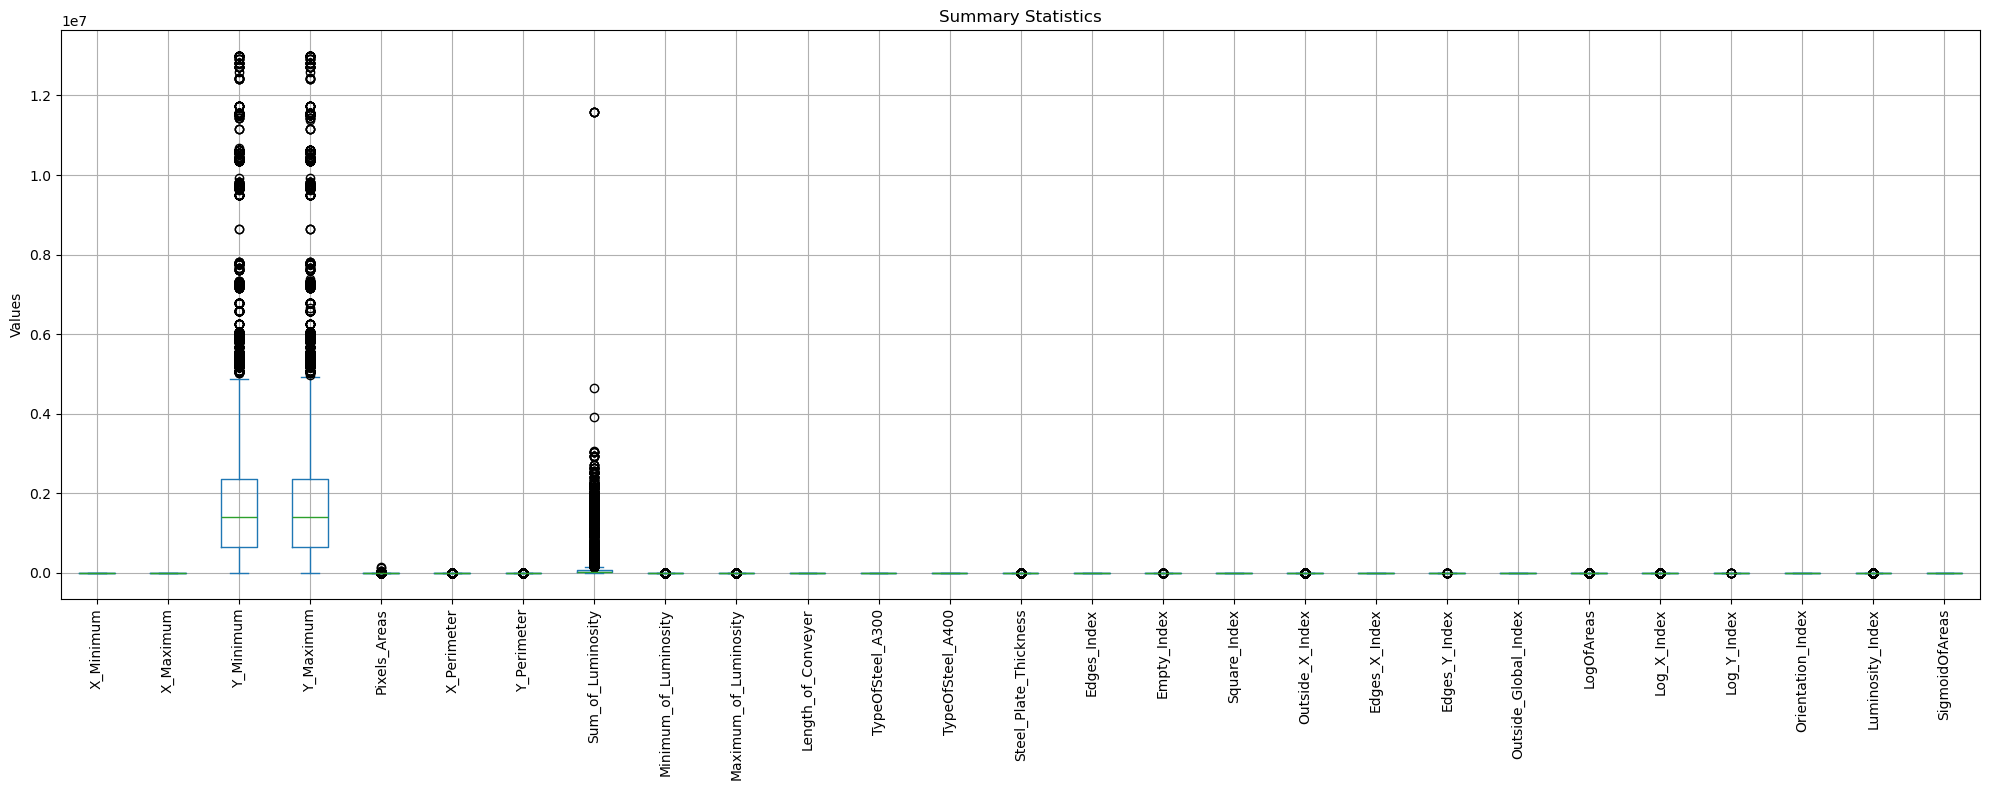

In [73]:
# Plot box plot for numeric columns
train.plot(kind='box', figsize=(20, 8), title='Box Plot of DataFrame Columns')
plt.title('Summary Statistics')
plt.ylabel('Values')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.savefig('describe_box_plot.png')
plt.show()

In [96]:
def compute_lower_upper_bounds(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound
    
def mask_outliers(df: pd.DataFrame):
    outlier_mask = pd.Series(False, index=df.index)
    for col in df.columns:
        lower_bound, upper_bound = compute_lower_upper_bounds(df, col)
        outlier_mask = outlier_mask | ((df[col] < lower_bound) | (df[col] > upper_bound))
    return outlier_mask

def remove_outliers(df: pd.DataFrame) -> tuple:
    outlier_counts = pd.Series(index=df.columns, dtype='float64')
    outlier_mask = mask_outliers(df)
    counter = 0
    for col in df.columns:
        lower_bound, upper_bound = compute_lower_upper_bounds(df, col)
        num_outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        if num_outliers>0: counter += 1
        outlier_counts[col] = num_outliers
        #print(f'{col}: {num_outliers}')
    print(f'\n number of columns with outliers: {counter} out of {len(df.columns)}')
    return df[~outlier_mask], outlier_counts, outlier_counts/df.shape[0]*100

In [97]:
train_cleaned, outlier_counts, outlier_percent = remove_outliers(train.copy())


 number of columns with outliers: 16 out of 27


In [92]:
outlier_counts

X_Minimum                   0.0
X_Maximum                   0.0
Y_Minimum                1118.0
Y_Maximum                1112.0
Pixels_Areas             3722.0
X_Perimeter              3717.0
Y_Perimeter              2785.0
Sum_of_Luminosity        3826.0
Minimum_of_Luminosity     211.0
Maximum_of_Luminosity    1292.0
Length_of_Conveyer          0.0
TypeOfSteel_A300            0.0
TypeOfSteel_A400            0.0
Steel_Plate_Thickness    2173.0
Edges_Index                 0.0
Empty_Index                61.0
Square_Index                0.0
Outside_X_Index          3641.0
Edges_X_Index               0.0
Edges_Y_Index              25.0
Outside_Global_Index        0.0
LogOfAreas                421.0
Log_X_Index              3325.0
Log_Y_Index                 8.0
Orientation_Index           0.0
Luminosity_Index          999.0
SigmoidOfAreas              0.0
dtype: float64

In [98]:
outlier_percent

X_Minimum                 0.000000
X_Maximum                 0.000000
Y_Minimum                 5.817160
Y_Maximum                 5.785941
Pixels_Areas             19.366252
X_Perimeter              19.340236
Y_Perimeter              14.490868
Sum_of_Luminosity        19.907383
Minimum_of_Luminosity     1.097872
Maximum_of_Luminosity     6.722514
Length_of_Conveyer        0.000000
TypeOfSteel_A300          0.000000
TypeOfSteel_A400          0.000000
Steel_Plate_Thickness    11.306520
Edges_Index               0.000000
Empty_Index               0.317394
Square_Index              0.000000
Outside_X_Index          18.944794
Edges_X_Index             0.000000
Edges_Y_Index             0.130080
Outside_Global_Index      0.000000
LogOfAreas                2.190541
Log_X_Index              17.300588
Log_Y_Index               0.041625
Orientation_Index         0.000000
Luminosity_Index          5.197981
SigmoidOfAreas            0.000000
dtype: float64

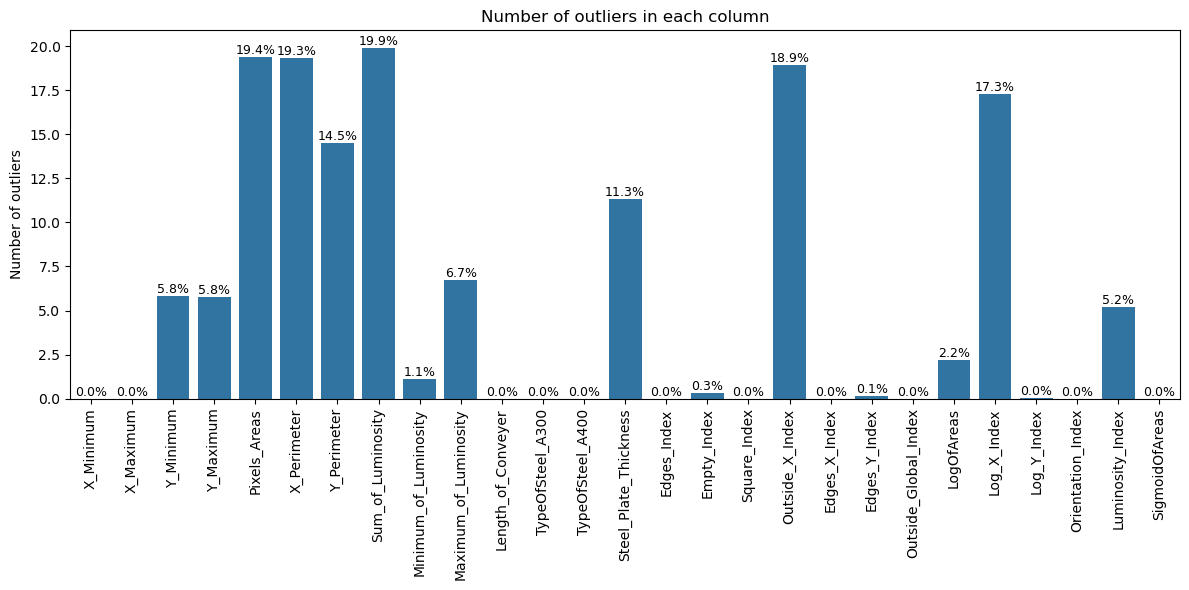

In [104]:
plt.figure(figsize=(12,6))
ax = sns.barplot(data=outlier_percent)
ax.bar_label(ax.containers[0], fmt="%.1f%%", fontsize=9)
plt.title('Number of outliers in each column')
plt.ylabel('Number of outliers')
plt.xticks(rotation=90)
# plt.grid(True)
plt.tight_layout()
plt.savefig('outliers_counts.png')
plt.show()

### Correlation

#### Heatmap

The heatmap is particularly useful for identifying patterns, trends, and relationships between variables in a dataset.
1. __Correlation between features__

    If the heatmap is based on a correlation matrix, it allows to observe the strength and direction of relationships between different variables.

    * Positive Correlation: Values closer to 1 (shown in darker colors on one side of the color spectrum) indicate a strong positive correlation—when one variable increases, the other tends to increase.
    * Negative Correlation: Values closer to -1 (shown in darker colors on the opposite side) indicate a strong negative correlation—when one variable increases, the other tends to decrease.
    * No Correlation: Values close to 0 (often lighter or neutral colors) indicate little to no linear relationship between variables.
        
    A correlations between different features in the dataset helps identify redundant features that are highly correlated.

2. __Pattern across rows and columns__

    A heatmap can reveal clusters of similar values across rows or columns, which may suggest:

    * Groups of samples (rows) with similar characteristics.
    * Features (columns) that behave similarly across samples.

    In this dataset, a heatmap of the 27 features across samples might show that certain features have consistently higher or lower values across certain groups of samples, which could suggest underlying patterns in the data.

3. __Anomalies and outliers__

    Heatmaps can help spot outliers or unusual patterns in the data.
    Extremely light or dark colors in an area where a more uniform color is expected can indicate anomalous data or an outlier.
    If one feature for a subset of samples stands out in the heatmap with very different colors compared to others, this could indicate data points that are far from the norm.

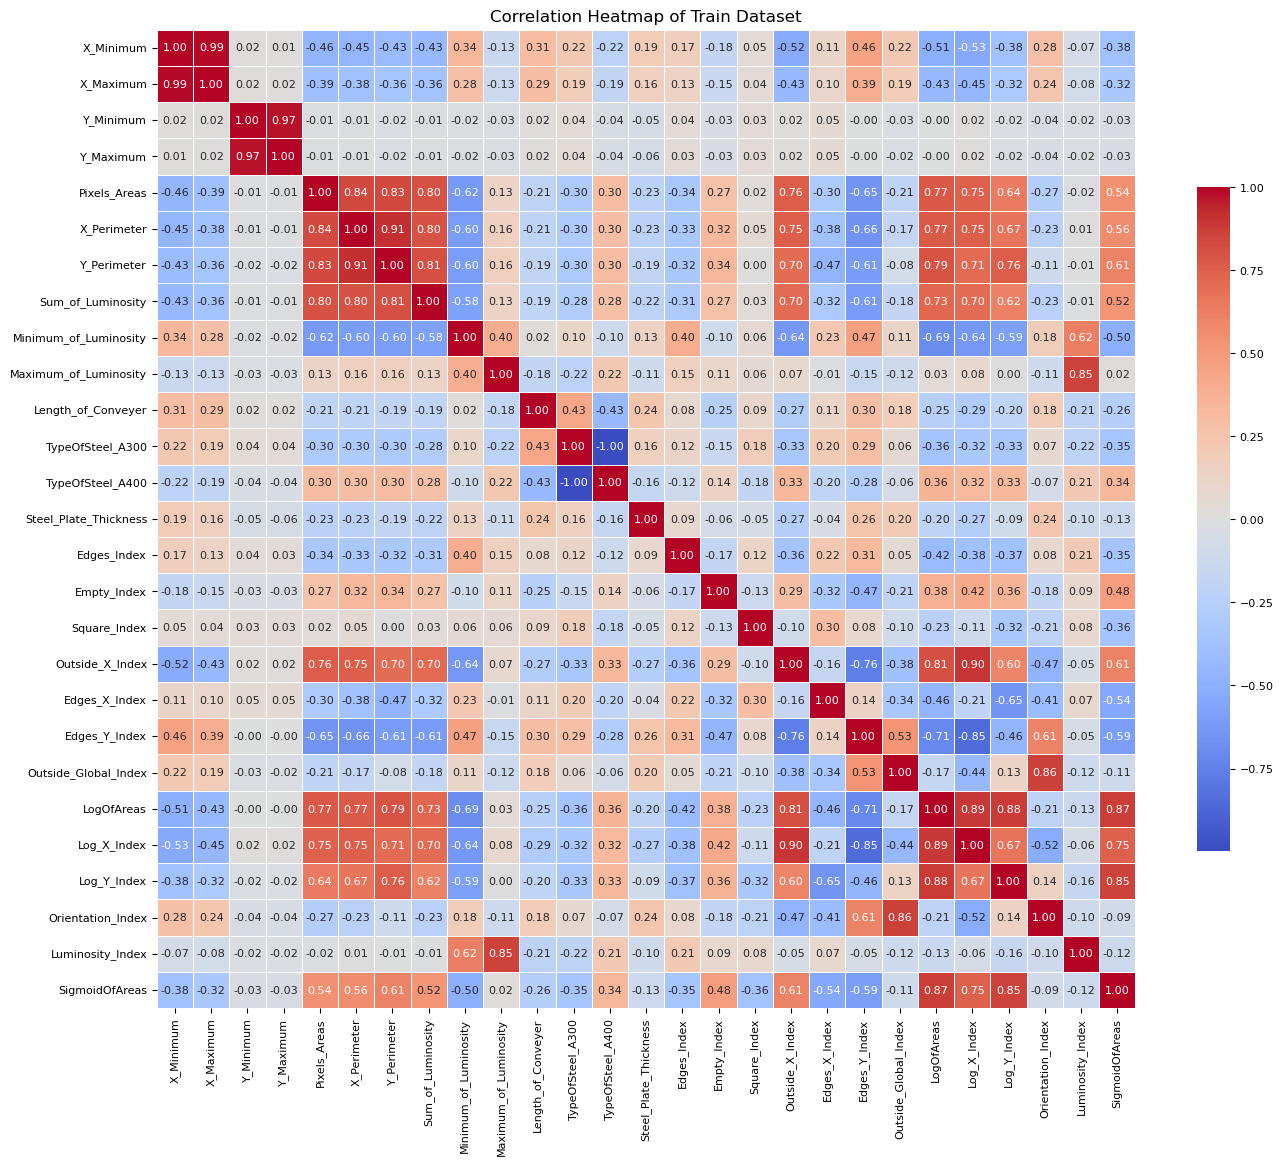

In [54]:
# Compute the correlation matrix
corr = train.corr()

plt.figure(figsize=(14, 14))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'fontsize': 8}, cmap='coolwarm', square=True, linewidths=0.5, cbar_kws={'shrink': 0.5})
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=8)
plt.title('Correlation Heatmap of Train Dataset')
plt.tight_layout()
plt.show()

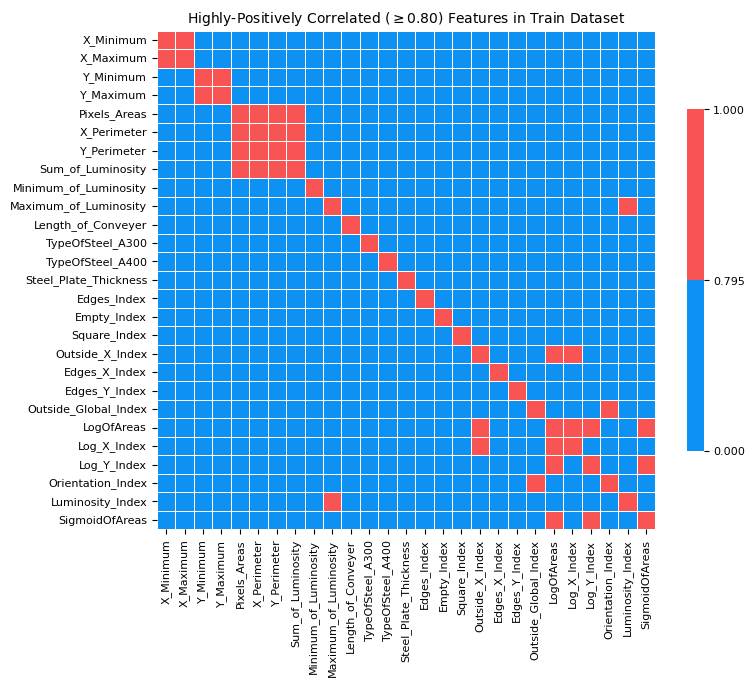

In [43]:
import matplotlib.colors as mcolors

corr = train.corr()
plt.figure(figsize=(8, 8))
cmap = mcolors.ListedColormap(['#0D92F4', '#F95454'])
bounds = [0, 0.795, 1] # Define the boundaries and normalization
norm = mcolors.BoundaryNorm(bounds, cmap.N)
ax = sns.heatmap(corr, annot=False, cmap=cmap, norm=norm, square=True, linewidths=0.5, cbar_kws={'shrink': 0.5})
# ax.grid(True, which='both', color='black', linestyle='-', linewidth=0.5)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=8)
plt.title(r'Highly-Positively Correlated ($\geq 0.80$) Features in Train Dataset', fontsize=10)
plt.tight_layout()

* Highly-positive correlations ($\geq 0.80$):
    * `X_Minimum` and `X_Maximum` (1 possible redudancy)
    * `Y_Minimum` and `Y_Maximum`   (1 possible redudancy)
    * `Pixels_Areas`, `X_Perimeter`, `Y_Perimeter`, and `Sum_of_Luminosity` (3 possible redudancy)
    * `Maximum_of_Luminosity` to `Luminosity_Index` (1 possible redudancy)
    * `Outside_Global_Index` to `Orientation_Index` (1 possible redudancy)
    * `LogOfAreas`, `Log_X_Index`, and `Log_Y_Index` (2 possible redudancy)
    * `LogOfAreas` and `Log_Y_Index` to `SigmoidOfAreas` (1 possible redudancy)
    * `LogOfAreas` and `Log_X_Index` to `Outside_X_Index` (1 possible redudancy)
    * `Orientation_Index` to `Outside_Global_Index` (1 possible redudancy)

There are a total of 12 features that are highly correlated to other features and seems to be redudant.

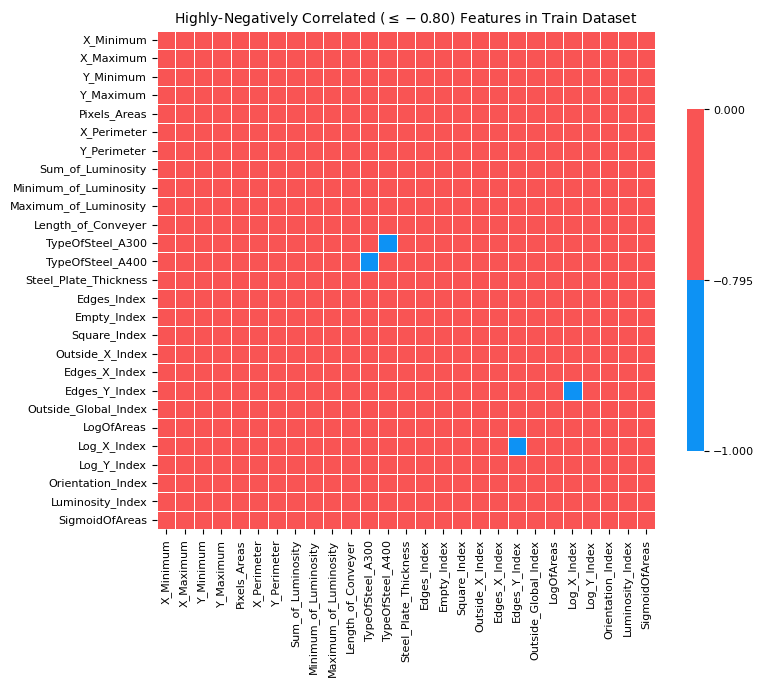

In [42]:
import matplotlib.colors as mcolors

corr = train.corr()
plt.figure(figsize=(8, 8))
cmap = mcolors.ListedColormap(['#0D92F4', '#F95454'])
bounds = [-1, -0.795, 0] # Define the boundaries and normalization
norm = mcolors.BoundaryNorm(bounds, cmap.N)
ax = sns.heatmap(corr, annot=False, cmap=cmap, norm=norm, square=True, linewidths=0.5, cbar_kws={'shrink': 0.5})
# ax.grid(True, which='both', color='black', linestyle='-', linewidth=0.5)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=8)
plt.title(r'Highly-Negatively Correlated ($\leq -0.80$) Features in Train Dataset', fontsize=10)
plt.tight_layout()

* Highly-negative correlation ($\leq -0.80$):
    * `Edges_Y_Index` and `Edges_Y_Index` (1 possbile redudancy)
    * `TypeOfSteel_A300` and `TypeOfSteel_A400` (1 possible redudancy, a plate is either of type A300 or A400. This is a categorical feature.)

    There are a total of 2 features that are highly correlated to other features and seems to be redudant.

    So, analyzing the correlation heatmap shows that there are 14 features that are highly correlated to other feature and could be removed to reduce the feature complexity. Removing those feature would result in 13 features to use for training.

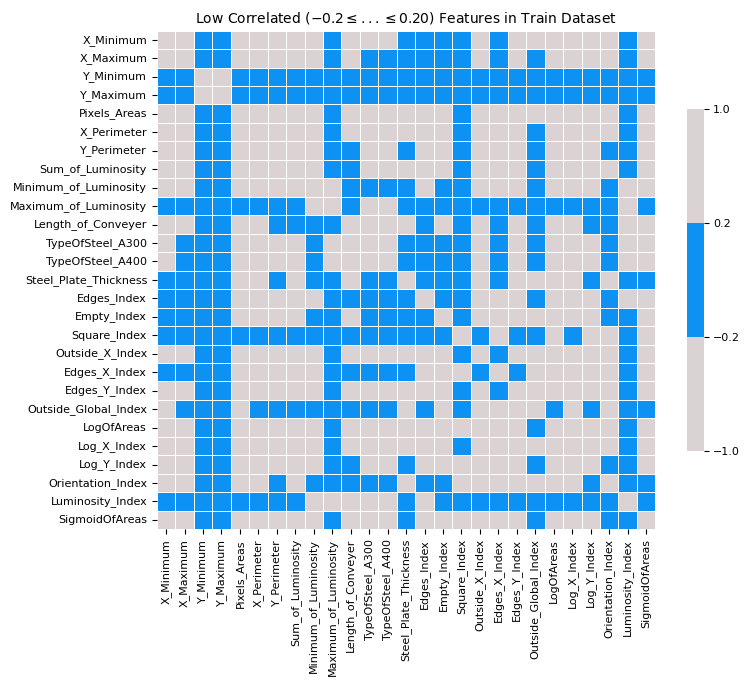

In [58]:
import matplotlib.colors as mcolors

corr = train.corr()
plt.figure(figsize=(8, 8))
cmap = mcolors.ListedColormap(['#DBD3D3', '#0D92F4', '#DBD3D3'])
bounds = [-1, -0.2, 0.2, 1] # Define the boundaries and normalization
norm = mcolors.BoundaryNorm(bounds, cmap.N)
ax = sns.heatmap(corr, annot=False, cmap=cmap, norm=norm, square=True, linewidths=0.5, cbar_kws={'shrink': 0.5})
# ax.grid(True, which='both', color='black', linestyle='-', linewidth=0.5)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=8)
plt.title(r'Low Correlated ($-0.2 \leq ... \leq 0.20$) Features in Train Dataset', fontsize=10)
plt.tight_layout()

#### Feature Reduction: PCA

The Principal Component Analysis (PCA) can help reduce dimensionality by transforming correlated features into a set of uncorrelated components.

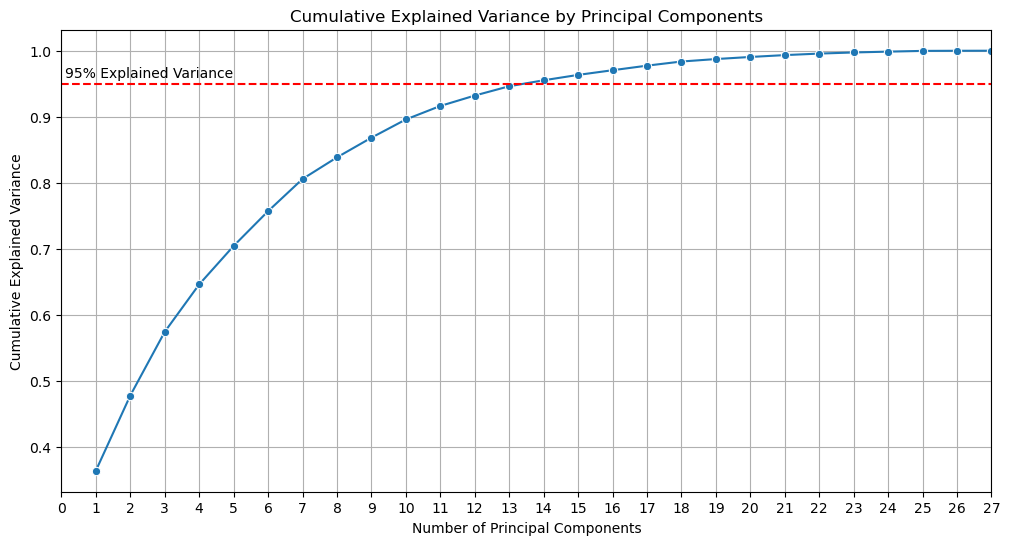

In [72]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)

pca = PCA(n_components=None)
pca_result = pca.fit(train_scaled)

explained_variance_ratio = pca_result.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(12, 6))
sns.lineplot(x=range(1, len(explained_variance_ratio) + 1), y=cumulative_variance_ratio, marker='o', linestyle='-')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.annotate('95% Explained Variance', xy=(0.1, 0.96))
plt.xlim(0, train.shape[1])
plt.xticks(np.arange(0, train.shape[1] + 1, 1))
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')

plt.grid(True)
plt.show()

In [64]:
n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1  # Find the smallest number of components to retain 95% variance
print(f"Number of components to retain 95% variance: {n_components}")

# Now transform the data using this number of components
pca = PCA(n_components=n_components)
pca_result_reduced = pca.fit_transform(train_scaled)

# The transformed data with reduced dimensions
print(f"Shape of the transformed data: {pca_result_reduced.shape}")

Number of components to retain 95% variance: 14
Shape of the transformed data: (19219, 14)


The result of PCA shows that 95% of the variability in the data could be retained by only considering 14 dimeensions. This is close to what is found using the correlation heatmap which was using 13 features for the training.

## Pre-Processing

In [ ]:
from sklearn.preprocessing import StandardScaler

categorical_columns = ['TypeOfSteel_A300', 'TypeOfSteel_A400', 'SteelPlateThickness']

## Multi-Output Classification

Since there are 7 targets, this is a multi-output classification problem, where each sample has multiple labels whose probabilities need to be predicted.

### 1. Random Forest Classifier
The `MultiOutputClassifier` is a wrapper around `RandonForestClassifier`, which is a single-output classifier in scikit-learn.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

clf = MultiOutputClassifier(RandomForestClassifier())
clf.fit(X_train, y_train)
probabilities = clf.predict_proba(X_test)

#### Hyper-parameter Tuning

Grid/Random Search

#### Cross-Validation

#### AUC-ROC Evaluation


### 2. XGBoost Classifier

The `XGBoost` must be wrapped with `MultiOutputClassifier` in order to achieve multi-output classification.

In [ ]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier

model = MultiOutputClassifier(xgb.XGBClassifier())
model.fit(X_train, y_train)
probabilities = model.predict_proba(X_test)

### 3. Neural Network

In neural network each output neuron corresponds to one target, and a sigmoid activation function is used to predict the probability for each of the 7 targets independently. The softmax is not used here since each instance could belong to more than one class.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(64, input_dim=27, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='sigmoid'))  # For multi-label classification

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32)
probabilities = model.predict(X_test)
